# LangChain RAG Pipeline

> **rag-project**(Next.js + Supabase pgvector)에서 구현한 RAG를 **Python LangChain + ChromaDB**로 전환

| 항목 | rag-project | langchain-rag |
|------|-----------|---------------|
| 언어 | TypeScript | Python |
| 프레임워크 | Next.js + Vercel AI SDK | LangChain |
| 벡터 DB | Supabase pgvector | ChromaDB (로컬) |
| 임베딩 | OpenAI text-embedding | HuggingFace all-MiniLM-L6-v2 |
| LLM | GPT-4o (직접) | GPT-4o (LangChain 래퍼) |

## 1. 환경 설정

In [1]:
import os
import sys
from dotenv import load_dotenv
from importlib.metadata import version

# .env에서 OPENAI_API_KEY 로드
load_dotenv()
assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY가 .env에 설정되어 있지 않습니다."

# 패키지 버전 확인
print(f"langchain: {version('langchain')}")
print(f"langchain-chroma: {version('langchain-chroma')}")
print(f"langchain-openai: {version('langchain-openai')}")
print(f"langchain-huggingface: {version('langchain-huggingface')}")
print(f"chromadb: {version('chromadb')}")
print(f"\nOpenAI API Key: ...{os.getenv('OPENAI_API_KEY')[-8:]}")

langchain: 1.2.6
langchain-chroma: 1.1.0
langchain-openai: 1.1.9
langchain-huggingface: 1.2.0
chromadb: 1.4.1

OpenAI API Key: ...E0ME0zwA


In [2]:
# 모듈 임포트
from modules.loader import load_documents
from modules.chunker import chunk_documents, CHUNK_SIZE, CHUNK_OVERLAP
from modules.vectorstore import (
    create_vectorstore, get_vectorstore, get_embedding_model, similarity_search
)
from modules.chain import (
    create_qa_chain, create_conversational_chain, ask
)

print("모듈 임포트 완료")

모듈 임포트 완료


## 2. 문서 로딩 & 청킹

**rag-project 대응:**
- 로딩: `app/api/ingest/route.ts` → `modules/loader.py`
- 청킹: `lib/chunker.ts` → `modules/chunker.py`
- 동일 파라미터: chunk_size=500, overlap=100

In [3]:
# 문서 로딩
documents = load_documents("./data")

print(f"\n--- 로드된 문서 ---")
for doc in documents:
    print(f"  {doc.metadata['source']} ({doc.metadata['file_type']}): {len(doc.page_content)}자")

  [TXT] nextjs-intro.txt: 1개 문서 로드
  [TXT] rag-explanation.txt: 1개 문서 로드
  [TXT] supabase-guide.txt: 1개 문서 로드
  [TXT] typescript-basics.txt: 1개 문서 로드
  [PDF] vercel-ai-sdk-guide.pdf: 1페이지 로드

총 5개 문서 로드 완료

--- 로드된 문서 ---
  nextjs-intro.txt (txt): 496자
  rag-explanation.txt (txt): 682자
  supabase-guide.txt (txt): 1004자
  typescript-basics.txt (txt): 893자
  vercel-ai-sdk-guide.pdf (pdf): 1222자


In [4]:
# 청킹
chunks = chunk_documents(documents)

print(f"\n설정: chunk_size={CHUNK_SIZE}, overlap={CHUNK_OVERLAP}")
print(f"\n--- 청크 목록 ---")
for i, chunk in enumerate(chunks):
    print(f"  [{i+1:2d}] {chunk.metadata['source']:30s} | {len(chunk.page_content):3d}자")

청킹 완료: 5개 문서 → 12개 청크
  청크 크기 범위: 184~496자

설정: chunk_size=500, overlap=100

--- 청크 목록 ---
  [ 1] nextjs-intro.txt               | 496자
  [ 2] rag-explanation.txt            | 496자
  [ 3] rag-explanation.txt            | 184자
  [ 4] supabase-guide.txt             | 469자
  [ 5] supabase-guide.txt             | 300자
  [ 6] supabase-guide.txt             | 304자
  [ 7] typescript-basics.txt          | 392자
  [ 8] typescript-basics.txt          | 349자
  [ 9] typescript-basics.txt          | 239자
  [10] vercel-ai-sdk-guide.pdf        | 487자
  [11] vercel-ai-sdk-guide.pdf        | 481자
  [12] vercel-ai-sdk-guide.pdf        | 335자


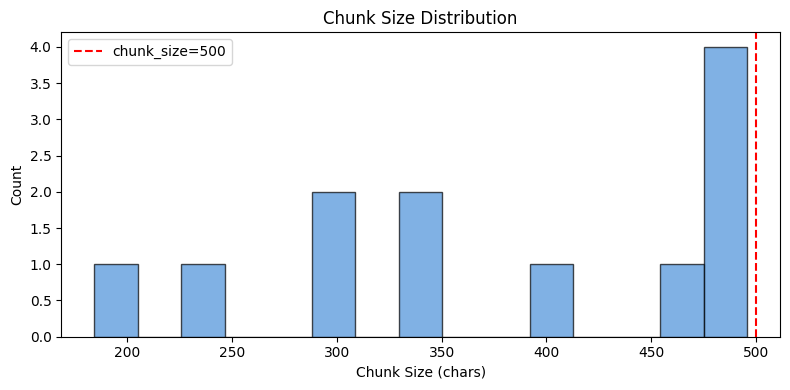

평균: 378자, 최소: 184자, 최대: 496자


In [5]:
# 청크 크기 분포 히스토그램
import matplotlib.pyplot as plt

chunk_sizes = [len(c.page_content) for c in chunks]

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(chunk_sizes, bins=15, edgecolor='black', alpha=0.7, color='#4A90D9')
ax.axvline(x=CHUNK_SIZE, color='red', linestyle='--', label=f'chunk_size={CHUNK_SIZE}')
ax.set_xlabel('Chunk Size (chars)')
ax.set_ylabel('Count')
ax.set_title('Chunk Size Distribution')
ax.legend()
plt.tight_layout()
plt.show()

print(f"평균: {sum(chunk_sizes)/len(chunk_sizes):.0f}자, 최소: {min(chunk_sizes)}자, 최대: {max(chunk_sizes)}자")

## 3. 벡터 저장소 (ChromaDB + HuggingFace 임베딩)

**rag-project 대응:**
- 임베딩: `lib/ai/embedding.ts` (OpenAI) → `modules/vectorstore.py` (HuggingFace 기본)
- 저장소: Supabase pgvector → ChromaDB (로컬)

| 비교 | rag-project | langchain-rag |
|------|-----------|---------------|
| 임베딩 모델 | OpenAI text-embedding-3-small | HuggingFace all-MiniLM-L6-v2 |
| 벡터 차원 | 1536 | 384 |
| 비용 | $0.02/1M tokens | 무료 (로컬) |
| 벡터 DB | Supabase pgvector (클라우드) | ChromaDB (로컬 파일) |
| 검색 방식 | SQL + cosine similarity | ChromaDB similarity_search |

In [6]:
# 기존 chroma_db가 있으면 삭제 후 새로 생성
import shutil
if os.path.exists("./chroma_db"):
    shutil.rmtree("./chroma_db")
    print("기존 chroma_db 삭제")

# HuggingFace 임베딩으로 벡터 스토어 생성
vectorstore = create_vectorstore(chunks, provider="huggingface")

벡터 스토어 생성 중... (provider=huggingface, 문서 12개)


벡터 스토어 생성 완료: /Users/ydk/workspace/ai-learning/langchain-rag/modules/../chroma_db


In [7]:
# 유사도 검색 테스트
print("=" * 60)
print("테스트 1: RAG 관련 검색")
print("=" * 60)
results_rag = similarity_search(vectorstore, "RAG란 무엇인가?", k=3)

print(f"\n{'=' * 60}")
print("테스트 2: Next.js 관련 검색")
print("=" * 60)
results_nextjs = similarity_search(vectorstore, "Next.js의 주요 특징", k=3)

print(f"\n{'=' * 60}")
print("테스트 3: Supabase 관련 검색")
print("=" * 60)
results_supa = similarity_search(vectorstore, "Supabase의 기능", k=3)

테스트 1: RAG 관련 검색

검색 쿼리: 'RAG란 무엇인가?'
상위 3개 결과:
  [1] score=1.2946 | source=typescript-basics.txt | TypeScript 기초 가이드

TypeScript는 JavaScript에 정적 타입 시스템을 추가한 프로그래밍 언어입니다. Microsoft...
  [2] score=1.3168 | source=rag-explanation.txt | RAG의 장점:
- 환각(hallucination) 감소: 실제 문서에 기반하여 답변하므로 거짓 정보 생성이 줄어듭니다.
- 최신 정보 반영: ...
  [3] score=1.3940 | source=typescript-basics.txt | 인터페이스(Interface):
객체의 구조를 정의하는 방법입니다. 클래스가 구현해야 할 메서드와 속성을 명시합니다.
예시:
interface ...

테스트 2: Next.js 관련 검색

검색 쿼리: 'Next.js의 주요 특징'
상위 3개 결과:
  [1] score=1.0067 | source=nextjs-intro.txt | Next.js는 React 기반의 풀스택 웹 프레임워크입니다. Vercel에서 개발하고 유지보수하고 있습니다.

주요 특징:
1. App Rou...
  [2] score=1.2899 | source=typescript-basics.txt | TypeScript 기초 가이드

TypeScript는 JavaScript에 정적 타입 시스템을 추가한 프로그래밍 언어입니다. Microsoft...
  [3] score=1.4654 | source=supabase-guide.txt | 무료 티어:
- 500MB 데이터베이스 저장소
- 1GB 파일 스토리지
- 50,000 월간 활성 사용자
- 무제한 API 요청

Supabas...

테스트 3: Supabase 관련 검색



검색 쿼리: 'Supabase의 기능'
상위 3개 결과:
  [1] score=0.7082 | source=supabase-guide.txt | 무료 티어:
- 500MB 데이터베이스 저장소
- 1GB 파일 스토리지
- 50,000 월간 활성 사용자
- 무제한 API 요청

Supabas...
  [2] score=1.1741 | source=supabase-guide.txt | Supabase 가이드

Supabase는 오픈소스 Firebase 대안으로, PostgreSQL 기반의 Backend-as-a-Service(...
  [3] score=1.4255 | source=typescript-basics.txt | TypeScript 기초 가이드

TypeScript는 JavaScript에 정적 타입 시스템을 추가한 프로그래밍 언어입니다. Microsoft...


### 임베딩 모델 비교 (참고)

`all-MiniLM-L6-v2`는 영어 텍스트에 최적화되어 있어, 한국어 쿼리에서는 정확도가 다소 낮을 수 있습니다.  
프로덕션 환경에서는 `multilingual-e5-large` 등 다국어 모델이나 OpenAI 임베딩을 권장합니다.

## 4. 기본 QA (RetrievalQA)

**rag-project 대응:** `app/api/chat/route.ts`

동작 흐름:
1. 질문 → retriever가 ChromaDB에서 관련 문서 검색
2. 검색된 문서 + 질문 → LLM(GPT-4o)이 답변 생성
3. 답변 + 출처 반환

In [8]:
# 기본 QA 체인 생성
qa_chain = create_qa_chain(vectorstore)

In [9]:
# 테스트 1: RAG에 대한 질문
result1 = ask(qa_chain, "RAG의 핵심 원리와 장점을 설명해주세요.")


Q: RAG의 핵심 원리와 장점을 설명해주세요.
A: RAG(Retrieval-Augmented Generation)의 핵심 원리는 LLM(대규모 언어 모델)이 답변을 생성하기 전에 관련 문서를 검색하여 컨텍스트로 제공하는 것입니다. 이를 통해 LLM이 학습하지 않은 최신 정보나 특정 도메인 지식에 대해서도 정확하게 답변할 수 있습니다.

RAG의 장점은 다음과 같습니다:
- 환각(hallucination) 감소: 실제 문서에 기반하여 답변하므로 거짓 정보 생성이 줄어듭니다.
- 최신 정보 반영: 문서를 업데이트하면 즉시 반영됩니다.
- 출처 추적 가능: 어떤 문서에서 정보를 가져왔는지 표시할 수 있습니다.
- 비용 효율적: 모델을 재학습(fine-tuning)하지 않아도 됩니다.

출처: 제공된 문서.

📄 참조 문서 (5개):
  - rag-explanation.txt
  - typescript-basics.txt
  - supabase-guide.txt


In [10]:
# 테스트 2: TypeScript에 대한 질문
result2 = ask(qa_chain, "TypeScript의 인터페이스와 제네릭에 대해 설명해주세요.")


Q: TypeScript의 인터페이스와 제네릭에 대해 설명해주세요.
A: TypeScript의 인터페이스(Interface)는 객체의 구조를 정의하는 방법으로, 클래스가 구현해야 할 메서드와 속성을 명시합니다. 예를 들어, `User`라는 인터페이스는 `id`, `name`, 그리고 선택적인 `email` 속성을 가질 수 있습니다.

```typescript
interface User {
  id: number;
  name: string;
  email?: string;  // optional 속성
}
```

제네릭(Generics)은 타입을 매개변수로 받아 재사용 가능한 컴포넌트를 만드는 기능입니다. 예를 들어, `identity`라는 함수는 제네릭을 사용하여 입력된 타입을 그대로 반환합니다.

```typescript
function identity<T>(arg: T): T { return arg; }
```

이러한 기능들은 TypeScript에서 코드의 유연성과 재사용성을 높이는 데 도움을 줍니다.

출처: TypeScript 기초 가이드

📄 참조 문서 (5개):
  - typescript-basics.txt
  - nextjs-intro.txt
  - vercel-ai-sdk-guide.pdf


In [11]:
# 테스트 3: Vercel AI SDK에 대한 질문
result3 = ask(qa_chain, "Vercel AI SDK는 어떤 기능을 제공하나요?")


Q: Vercel AI SDK는 어떤 기능을 제공하나요?
A: Vercel AI SDK는 AI 기반 애플리케이션을 구축하기 위한 TypeScript 라이브러리로, LLM(대규모 언어 모델)로부터 스트리밍 텍스트 응답을 처리하는 `streamText` 기능을 제공합니다. 또한, 제공자 간의 차이를 추상화하여 모델 간 전환을 쉽게 할 수 있도록 합니다. 

출처: Vercel AI SDK Guide

📄 참조 문서 (5개):
  - vercel-ai-sdk-guide.pdf
  - typescript-basics.txt
  - rag-explanation.txt


In [12]:
# 테스트 4: 문서에 없는 정보 질문 (환각 방지 테스트)
result4 = ask(qa_chain, "Docker Compose로 마이크로서비스를 배포하는 방법은?")


Q: Docker Compose로 마이크로서비스를 배포하는 방법은?
A: 제공된 문서에서 관련 정보를 찾을 수 없습니다.

📄 참조 문서 (5개):
  - nextjs-intro.txt
  - supabase-guide.txt
  - typescript-basics.txt
  - rag-explanation.txt


## 5. 대화형 RAG (멀티턴)

rag-project에서는 단일 질문-응답만 지원했지만, LangChain의 `create_history_aware_retriever`를 사용하면 **이전 대화 맥락을 고려한 검색**이 가능합니다.

**동작 원리:**
1. 이전 대화 기록 + 새 질문 → LLM이 독립적인 질문으로 재작성
2. 재작성된 질문으로 ChromaDB 검색
3. 검색된 문서 + 전체 대화 기록 → LLM이 답변 생성

In [13]:
# 대화형 RAG 체인 생성
conv_chain = create_conversational_chain(vectorstore)
chat_history = []

In [14]:
# 대화 1: 첫 질문
result = ask(conv_chain, "RAG란 무엇인가요?", chat_history)
chat_history = result["chat_history"]


Q: RAG란 무엇인가요?
A: RAG(Retrieval-Augmented Generation)는 검색 증강 생성이라고 불리는 AI 기술입니다. RAG의 핵심 원리는 LLM(대규모 언어 모델)이 답변을 생성하기 전에, 먼저 관련 문서를 검색하여 컨텍스트로 제공하는 것입니다. 이를 통해 LLM이 학습하지 않은 최신 정보나 특정 도메인 지식에 대해서도 정확하게 답변할 수 있습니다.

RAG 파이프라인 구성:
1. 문서 수집(Ingestion): 원본 문서를 작은 청크(chunk)로 분할합니다.
2. 임베딩 생성: 각 청크를 벡터(숫자 배열)로 변환합니다. OpenAI의 text-embedding-3-small 모델이 대표적입니다.
3. 벡터 저장: 생성된 벡터를 pgvector 같은 벡터 데이터베이스에 저장합니다.
4. 쿼리 처리: 사용자 질문도 임베딩으로 변환한 뒤, 코사인 유사도로 가장 관련 있는 청크를 검색합니다.
5. 응답 생성: 검색된 청크를 시스템 프롬프트에 포함시켜 LLM이 근거 있는 답변을 생성합니다.

출처: TypeScript 기초 가이드

📄 참조 문서 (5개):
  - typescript-basics.txt
  - rag-explanation.txt


In [15]:
# 대화 2: 이전 대화를 참조하는 후속 질문 ("그것" = RAG)
result = ask(conv_chain, "그것의 장점은 무엇인가요?", chat_history)
chat_history = result["chat_history"]


Q: 그것의 장점은 무엇인가요?
A: RAG의 장점은 다음과 같습니다:

1. 환각(hallucination) 감소: 실제 문서에 기반하여 답변하므로 거짓 정보 생성이 줄어듭니다.
2. 최신 정보 반영: 문서를 업데이트하면 즉시 반영됩니다.
3. 출처 추적 가능: 어떤 문서에서 정보를 가져왔는지 표시할 수 있습니다.
4. 비용 효율적: 모델을 재학습(fine-tuning)하지 않아도 됩니다.

출처: RAG의 장점

📄 참조 문서 (5개):
  - rag-explanation.txt
  - typescript-basics.txt


In [16]:
# 대화 3: 추가 맥락 활용
result = ask(conv_chain, "그러면 이 기술을 구현할 때 어떤 단계를 거치나요?", chat_history)
chat_history = result["chat_history"]


Q: 그러면 이 기술을 구현할 때 어떤 단계를 거치나요?
A: RAG 기술을 구현할 때는 다음과 같은 단계를 거칩니다:

1. 문서 수집(Ingestion): 원본 문서를 작은 청크(chunk)로 분할합니다.
2. 임베딩 생성: 각 청크를 벡터(숫자 배열)로 변환합니다. OpenAI의 text-embedding-3-small 모델이 대표적입니다.
3. 벡터 저장: 생성된 벡터를 pgvector 같은 벡터 데이터베이스에 저장합니다.
4. 쿼리 처리: 사용자 질문도 임베딩으로 변환한 뒤, 코사인 유사도로 가장 관련 있는 청크를 검색합니다.
5. 응답 생성: 검색된 청크를 시스템 프롬프트에 포함시켜 LLM이 근거 있는 답변을 생성합니다.

출처: RAG 파이프라인 구성

📄 참조 문서 (5개):
  - rag-explanation.txt
  - typescript-basics.txt


## 종합 비교: rag-project vs langchain-rag

| 구분 | rag-project (TypeScript) | langchain-rag (Python) |
|------|------------------------|------------------------|
| **문서 로딩** | pdf-parse + File API | PyPDFLoader + TextLoader |
| **청킹** | 직접 구현 (chunkText) | RecursiveCharacterTextSplitter |
| **임베딩** | OpenAI text-embedding-3-small | HuggingFace all-MiniLM-L6-v2 |
| **벡터 DB** | Supabase pgvector (SQL) | ChromaDB (로컬 파일) |
| **QA 체인** | 직접 프롬프트 조합 | create_retrieval_chain |
| **대화형** | 미지원 | history_aware_retriever |
| **배포** | Vercel 서버리스 | 로컬/노트북 실행 |
| **비용** | OpenAI 임베딩 + LLM | LLM만 (임베딩 무료) |

### 핵심 차이점

1. **추상화 수준**: LangChain은 RAG 파이프라인을 고수준 API(`create_retrieval_chain`)로 추상화. rag-project는 각 단계를 직접 구현.
2. **벡터 DB**: pgvector는 SQL로 검색 (서버), ChromaDB는 로컬 파일 기반 (프로토타이핑에 적합).
3. **임베딩 비용**: HuggingFace 로컬 모델은 무료이지만, 다국어 성능은 OpenAI보다 낮을 수 있음.
4. **대화 기능**: LangChain의 `history_aware_retriever`가 멀티턴 대화를 자연스럽게 지원.